# Defect Detection Tutorial and Walkthrough

This notebook shows complete pathway of deploying faster-rCNN for automated defect analysis in electron micrograph images. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import imageUtils, postProcessing, DefectDetectionDataset, evaluation, visualization

In [3]:
import numpy as np
import os

from chainercv.links import FasterRCNNVGG16
from chainercv.visualizations import vis_bbox
from chainercv.utils import write_image
import chainer
import math
from chainercv import utils
%matplotlib inline
import matplotlib.pyplot as plt

## Loading data

Specify data root directory if image data exists

In [4]:
root = '/home/wei/Data/Loop_detection'

Dowload data if no image data exists. The data is available at [Dropbox](https://www.dropbox.com/sh/ttl5u14uzqxrili/AAAa1XMxP9AVJPQ3ie7xZZVxa?dl=0). Download and extract it to the data root directory (create one if it doesn't exist).

In [5]:
dataset = DefectDetectionDataset(data_dir=root, split='train')
dataset_test = DefectDetectionDataset(data_dir=root, split='test')
human_test = DefectDetectionDataset(data_dir=root, split='humantest')

We can use `visualization.vis_bbox` to view the image from the dataset.

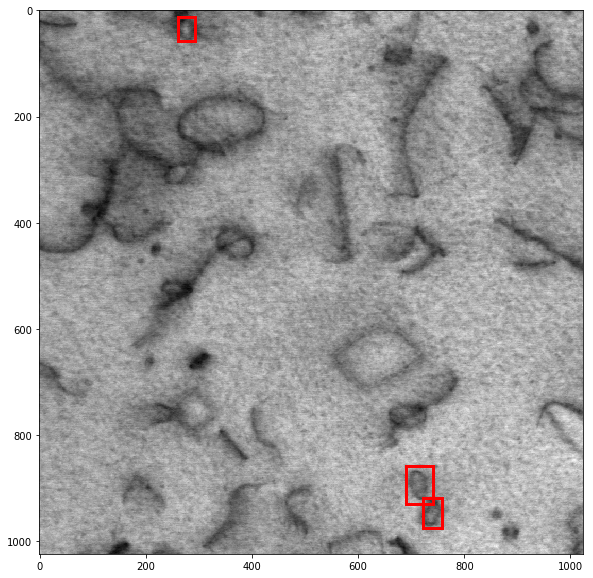

In [6]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1, 1, 1)
img, bbox, label = dataset[7]
visualization.vis_bbox(img, bbox, label, ax=ax1)
plt.show()

## Data augmentations
We can populate more training images by data augmentation techniques, e.g. image rotation, image expansion/crop, image flipping, brightness/contrast adjustment. Here is two examples of the data augmentation techniques. For more data augmentation methods, please check `utils/add_transforms` and `chainercv/transforms/`.

In [7]:
from utils.add_transforms import rotate_bbox
from chainercv import transforms

We can randomly rotate the images. (The rotation is triggled by 50% chance. Run the section again if you don't see any change.)

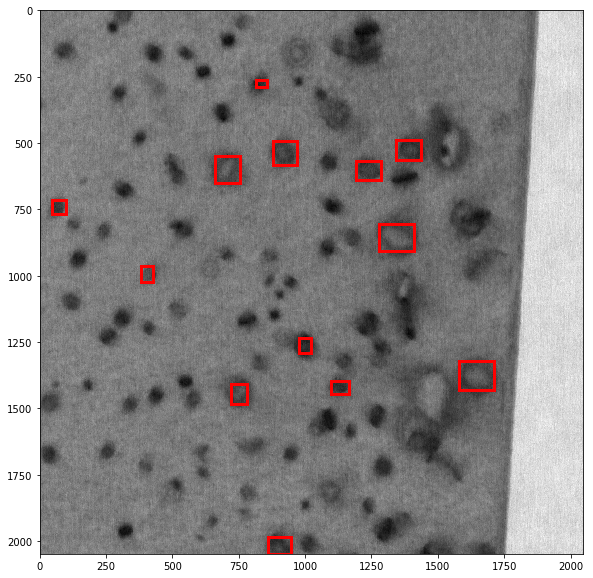

In [8]:
img, bbox, label = dataset[210]
_, H, W = img.shape
img, params = transforms.random_rotate(img, return_param=True)
bbox = rotate_bbox(bbox, (H, W), params['k'])
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1, 1, 1)
visualization.vis_bbox(img, bbox, label, ax=ax1)
plt.show()

In [9]:
from utils import random_crop_with_bbox_constraints

We can randomly expand and crop the images. (The expansion and cropping is triggled by chance. Run the section again if you don't see any change.)

In [18]:
img.shape

(3, 2048, 2048)

In [23]:
img.mean(axis=1).mean(axis=1).reshape(-1,1,1)

array([[[ 122.99362183]],

       [[ 135.54393005]],

       [[ 128.01730347]]], dtype=float32)

In [ ]:
img, bbox, label = dataset[210]
if np.random.randint(2):
    fill_value = img.mean(axis=1).mean(axis=1).reshape(-1,1,1)
    img, param = transforms.random_expand(img, max_ratio=2, fill=fill_value, return_param=True)
    bbox = transforms.translate_bbox(
        bbox, y_offset=param['y_offset'], x_offset=param['x_offset'])
# Random crop
img, param = random_crop_with_bbox_constraints(
    img, bbox, min_scale=0.5, max_aspect_ratio=1.5, return_param=True)        
bbox, param = transforms.crop_bbox(
    bbox, y_slice=param['y_slice'], x_slice=param['x_slice'],
    allow_outside_center=False, return_param=True)
label = label[param['index']]
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1, 1, 1)
visualization.vis_bbox(img, bbox, label, ax=ax1)
plt.show()

# Training Faster-RCNN

In case the training takes a long time, the trained model for testing is available at [HERE](https://drive.google.com/open?id=16x88tZxC2zsmIMhpUBEsWcgl9rJlNVT0). Download it and put it under ```./result/``` folder.

To train the model, please run `sample_train.py` file for better reporting visualizations.

If train on GPU, set flag ```use_gpu``` to True; otherwise set to False

In [8]:
use_gpu = False

In [ ]:
import numpy as np

import chainer
from chainer.datasets import TransformDataset
from chainer import training
from chainer.training import extensions
from chainer.training.triggers import ManualScheduleTrigger
from chainercv.extensions import DetectionVOCEvaluator
from chainercv.links import FasterRCNNVGG16
from chainercv.links.model.faster_rcnn import FasterRCNNTrainChain
from chainercv import transforms
from utils import DefectDetectionDataset
from utils import rotate_bbox, random_resize, random_distort, random_crop_with_bbox_constraints
import matplotlib.pyplot as plt

class Transform(object):

    def __init__(self, faster_rcnn):
        self.faster_rcnn = faster_rcnn

    def __call__(self, in_data):
        img, bbox, label = in_data
        _, H, W = img.shape

        # random brightness and contrast
        img = random_distort(img)

        # rotate
        img, params = transforms.random_rotate(img, return_param=True)
        _, t_H, t_W = img.shape
        bbox = rotate_bbox(bbox, (H, W), params['k'])
        
        # Random expansion
        if np.random.randint(2):
            img, param = transforms.random_expand(img, max_ratio=2, return_param=True)
            bbox = transforms.translate_bbox(
                bbox, y_offset=param['y_offset'], x_offset=param['x_offset'])

        # Random crop
        img, param = random_crop_with_bbox_constraints(
            img, bbox, return_param=True)        
        bbox, param = transforms.crop_bbox(
            bbox, y_slice=param['y_slice'], x_slice=param['x_slice'],
            allow_outside_center=False, return_param=True)
        label = label[param['index']]
        
        _, t_H, t_W = img.shape

        img = self.faster_rcnn.prepare(img)
        _, o_H, o_W = img.shape
        bbox = transforms.resize_bbox(bbox, (t_H, t_W), (o_H, o_W))

        # horizontally & vertical flip
        img, params = transforms.random_flip(
            img, x_random=True, y_random=True, return_param=True)
        bbox = transforms.flip_bbox(
            bbox, (o_H, o_W), x_flip=params['x_flip'], y_flip=params['y_flip'])

        scale = o_H / t_H

        return img, bbox, label, scale


def main():
    bbox_label_names = ('loop')

    n_itrs = 70000
    n_step = 50000
    np.random.seed(0)
    train_data = DefectDetectionDataset(split='train')
    test_data = DefectDetectionDataset(split='test')
    proposal_params = {'min_size': 8}

    faster_rcnn = FasterRCNNVGG16(n_fg_class=1, pretrained_model='imagenet', ratios=[0.5, 1, 2],
                                  anchor_scales=[1, 4, 8, 16], min_size=512, max_size=1024,
                                  proposal_creator_params=proposal_params)
    faster_rcnn.use_preset('evaluate')
    model = FasterRCNNTrainChain(faster_rcnn)
    chainer.cuda.get_device_from_id(0).use()
    model.to_gpu()
    optimizer = chainer.optimizers.MomentumSGD(lr=1e-3, momentum=0.9)
    optimizer.setup(model)
    optimizer.add_hook(chainer.optimizer.WeightDecay(rate=0.0005))
    train_data = TransformDataset(train_data, Transform(faster_rcnn))
    train_iter = chainer.iterators.MultiprocessIterator(
        train_data, batch_size=1, n_processes=None, shared_mem=100000000)
    test_iter = chainer.iterators.SerialIterator(
        test_data, batch_size=1, repeat=False, shuffle=False)
    updater = chainer.training.updater.StandardUpdater(
        train_iter, optimizer, device=0)
    trainer = training.Trainer(
        updater, (n_itrs, 'iteration'), out='result')
    trainer.extend(
        extensions.snapshot_object(model.faster_rcnn, 'snapshot_model_{.updater.iteration}.npz'), 
        trigger=(n_itrs/5, 'iteration'))
    trainer.extend(extensions.ExponentialShift('lr', 0.1),
                   trigger=(n_step, 'iteration'))
    log_interval = 50, 'iteration'
    plot_interval = 100, 'iteration'
    print_interval = 20, 'iteration'
    trainer.extend(chainer.training.extensions.observe_lr(),
                   trigger=log_interval)
    trainer.extend(extensions.LogReport(trigger=log_interval))
    trainer.extend(extensions.ProgressBar(update_interval=5))
    trainer.run()

if __name__ == '__main__':
    main()

# Testing

In case the training takes a long time, the trained model for testing is available at [HERE](https://drive.google.com/open?id=16x88tZxC2zsmIMhpUBEsWcgl9rJlNVT0). Download it and put it under ```./result/``` folder.

If need to use CPU for testing, set ```use_gpu``` to False. Otherwise, set it to True

In [10]:
use_gpu = True
proposal_params = {'min_size': 8}
model = FasterRCNNVGG16(n_fg_class=1, ratios=[0.5, 1, 2], anchor_scales=[1, 4, 8, 16], 
                        min_size=512, pretrained_model='result/snapshot_model_0413.npz', 
                        proposal_creator_params=proposal_params)
if use_gpu:
    chainer.cuda.get_device_from_id(0).use()
    model.to_gpu()

In [7]:
bbox_label_names = ('loop')

View the prediction results on test dataset

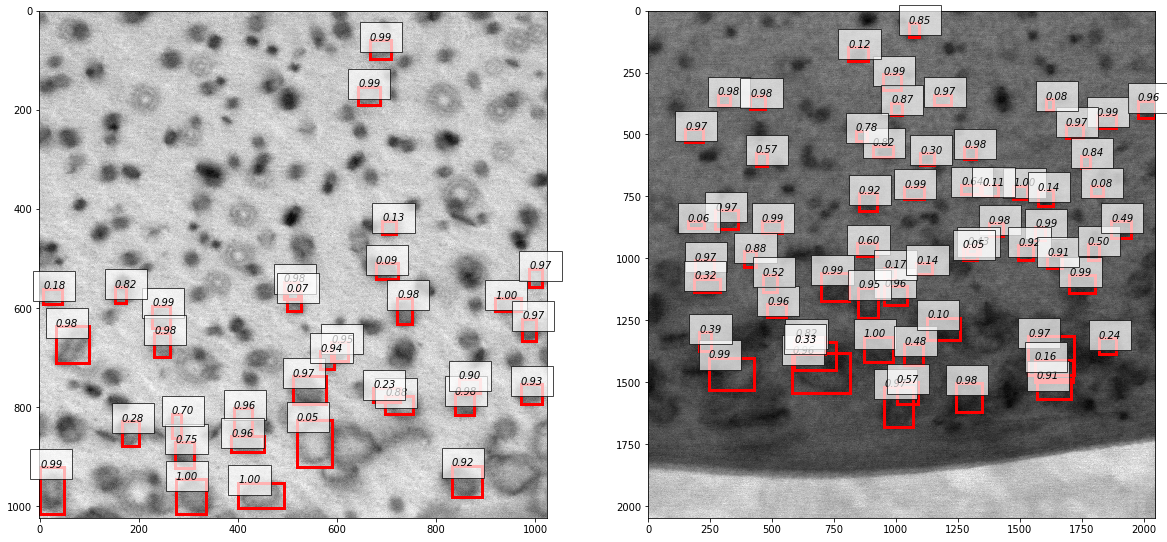

In [40]:
img_0, bbs_1, _ = dataset_test[3]
img_1, bbs_2, _ = dataset_test[14]
model.score_thresh = 0.05
# Note that `predict` takes a list of images.
bboxes, labels, scores = model.predict([img_0, img_1])
# Visualize output of the first image on the left and
# the second image on the right.
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
visualization.vis_bbox(img_0, bboxes[0], labels[0], scores[0], ax=ax1)
visualization.vis_bbox(img_1, bboxes[1], labels[1], scores[1], ax=ax2)
plt.show()

Compare with the ground truth

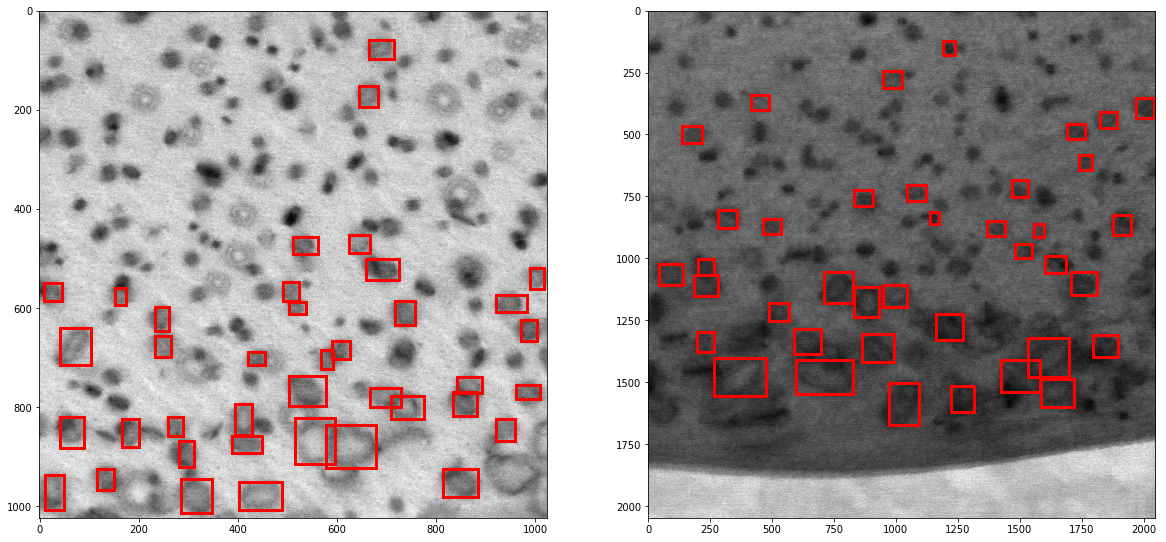

In [41]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
visualization.vis_bbox(img_0, bbs_1, ax=ax1)
visualization.vis_bbox(img_1, bbs_2, ax=ax2)
plt.show()

## Evaluations
We can check the recall and precision for the predicted bounding boxes

In [8]:
from utils import compute_score_by_centroid, evaluate_set_by_centroid, evaluate_set_by_defect_size,pr_plot_by_size

In [11]:
%time recalls, precisions = evaluate_set_by_centroid(model, dataset_test, threshold=0.05)
print("Average recall ", sum(recalls)/len(recalls))
print("Average precision ", sum(precisions)/len(precisions))

CPU times: user 5.85 s, sys: 931 ms, total: 6.78 s
Wall time: 6.7 s
Average recall  0.8589027395507839
Average precision  0.8448120127454646


In [48]:
bins = 20
sz_range = (15,130)

In [73]:
recalls, precisions = evaluate_set_by_defect_size(model, dataset_test, num_bins=bins, size_range=sz_range, threshold=0.05)

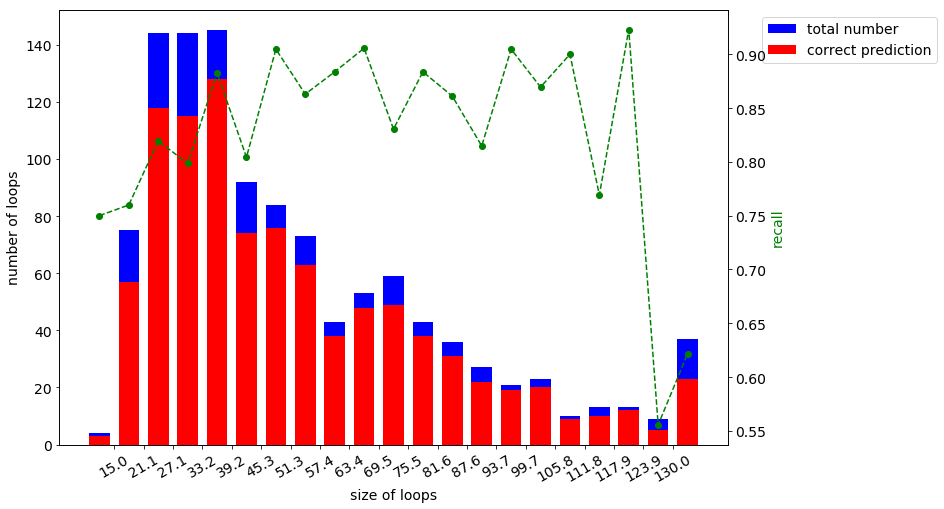

In [74]:
pr_plot_by_size(recalls, label='recall', num_bins=bins, size_range=sz_range)

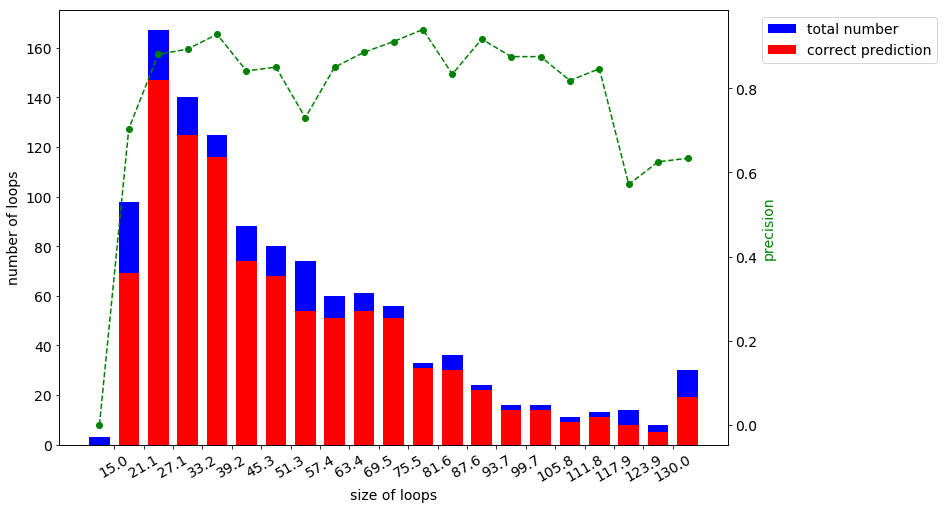

In [75]:
pr_plot_by_size(precisions, label='precision', num_bins=bins, size_range=sz_range)

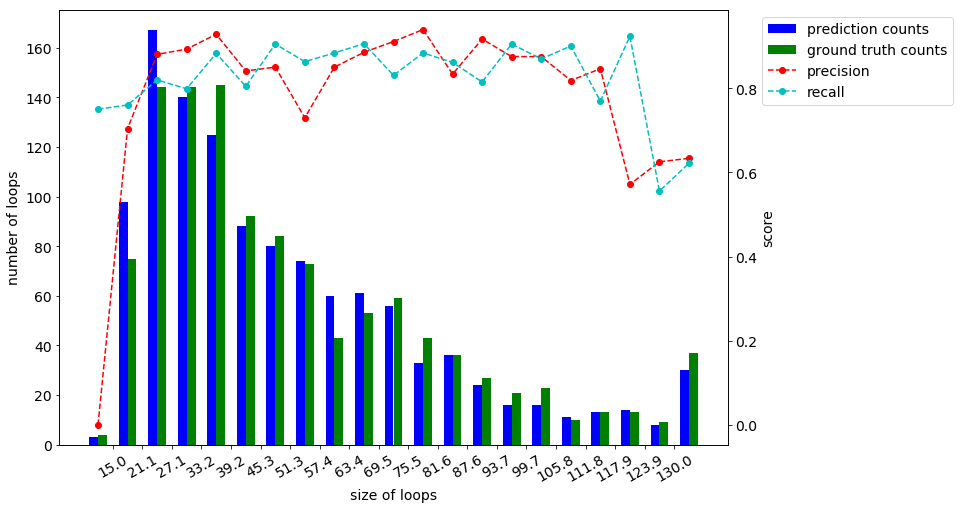

In [76]:
evaluation.size_distribution_comparison(precisions, recalls, num_bins=bins, size_range=sz_range)

We can do similar things with the human test set.

In [70]:
%time recalls, precisions = evaluate_set_by_centroid(model, human_test, threshold=0.05)

CPU times: user 1.12 s, sys: 240 ms, total: 1.36 s
Wall time: 1.34 s


In [71]:
print("Average recall ", sum(recalls)/len(recalls))
print("Average precision ", sum(precisions)/len(precisions))

Average recall  0.8558831638528034
Average precision  0.8683839022016125


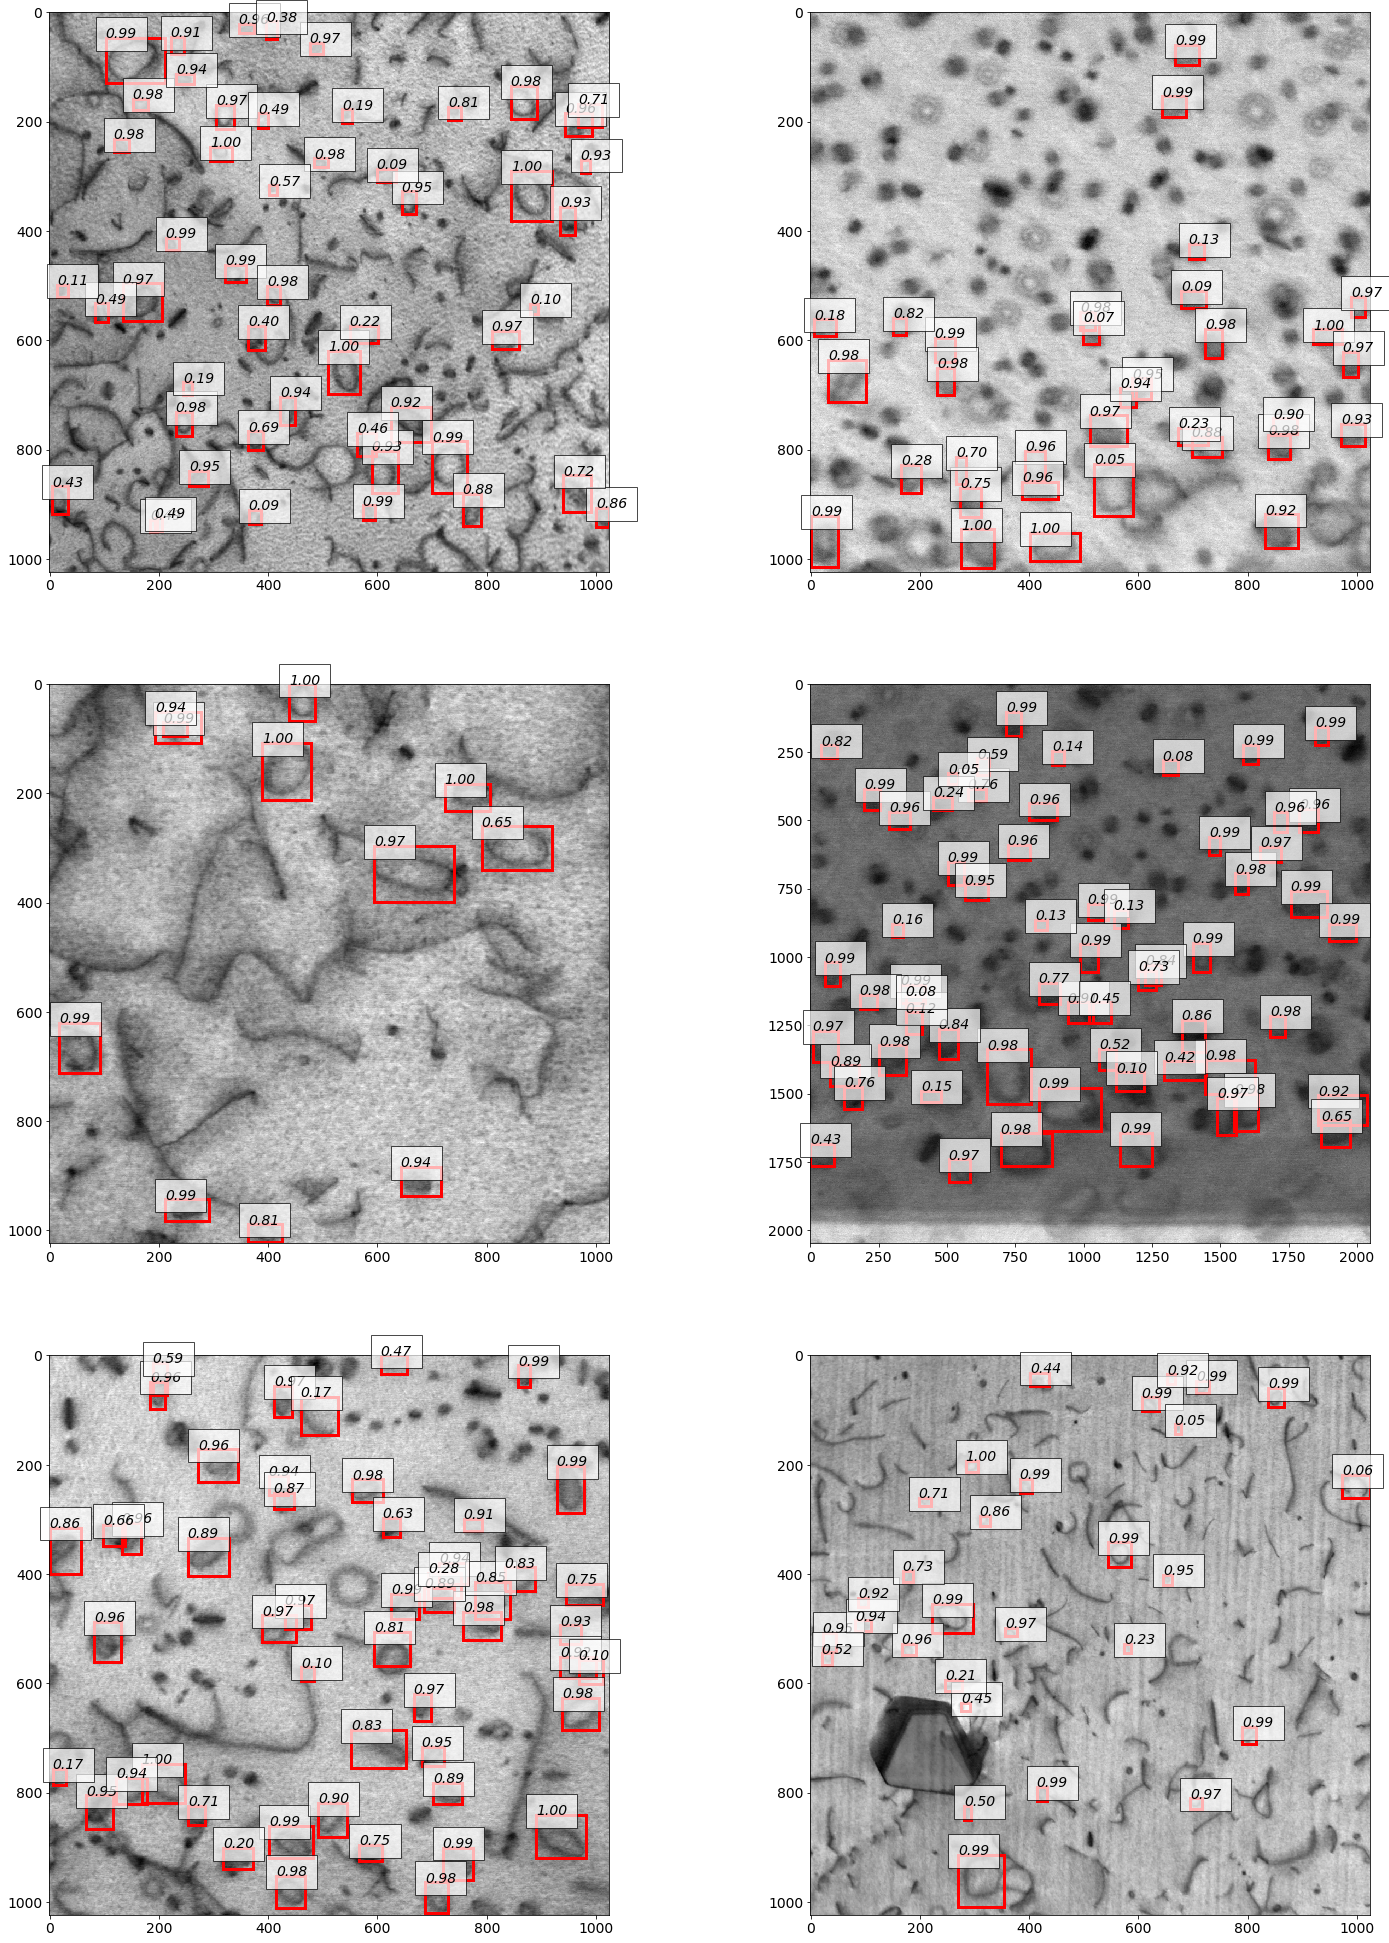

In [72]:
img_list = [ins[0] for ins in human_test]
bbs_list = [ins[1] for ins in human_test]
model.score_thresh = 0.05
# Note that `predict` takes a list of images.
bboxes, labels, scores = model.predict(img_list)
# Visualize output of the first image on the left and
# the second image on the right.
fig = plt.figure(figsize=(25,35))
for i, img in enumerate(img_list):
    ax = fig.add_subplot(3, 2, i+1)
    visualization.vis_bbox(img, bboxes[i], labels[i], scores[i], ax=ax)
plt.show()

## Fitting ellipse for the loops in the images

In [62]:
from utils.evaluation import analyze_and_fitting

CPU times: user 5.17 s, sys: 196 ms, total: 5.36 s
Wall time: 5.34 s


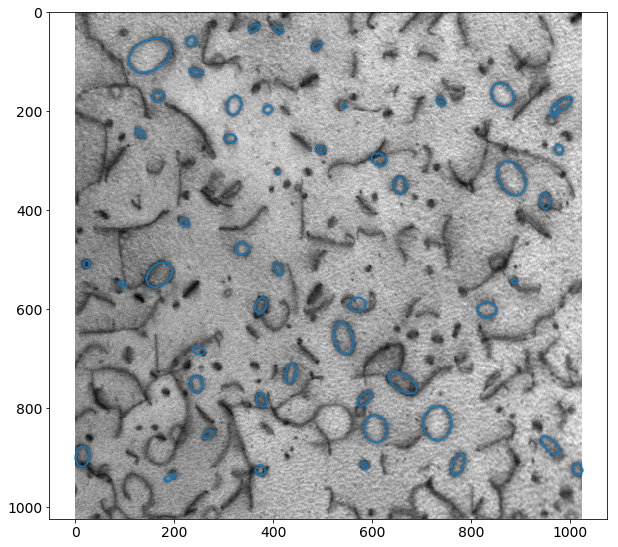

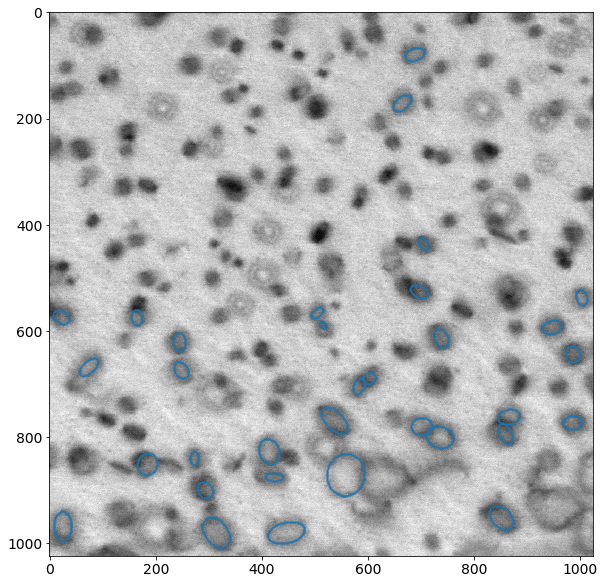

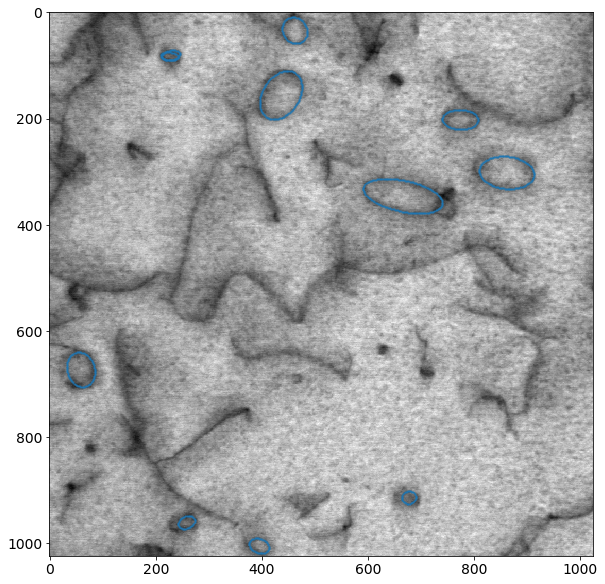

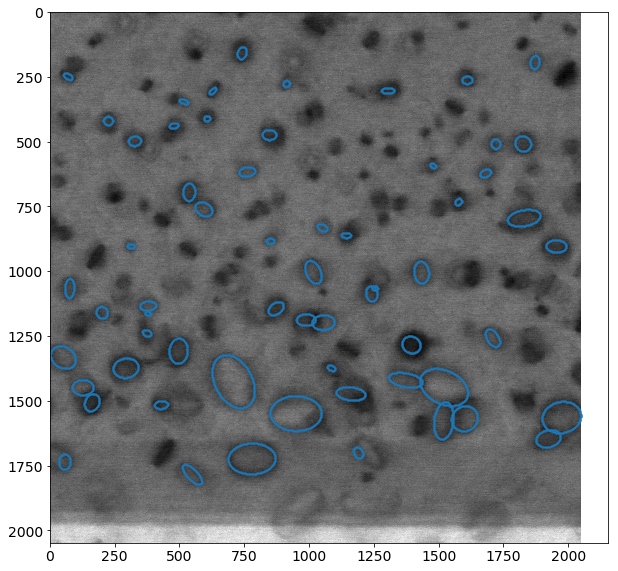

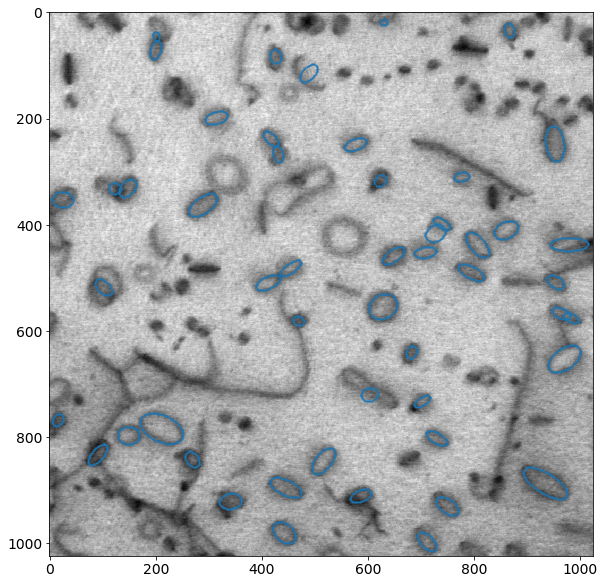

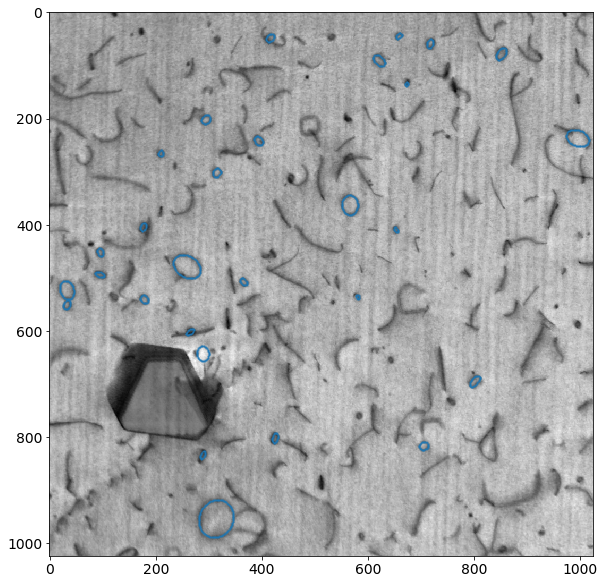

In [69]:
%time analyze_and_fitting(model, human_test, threshold=0.05)

In [77]:
recalls, precisions = evaluate_set_by_defect_size(model, human_test, num_bins=bins, size_range=sz_range, threshold=0.05)

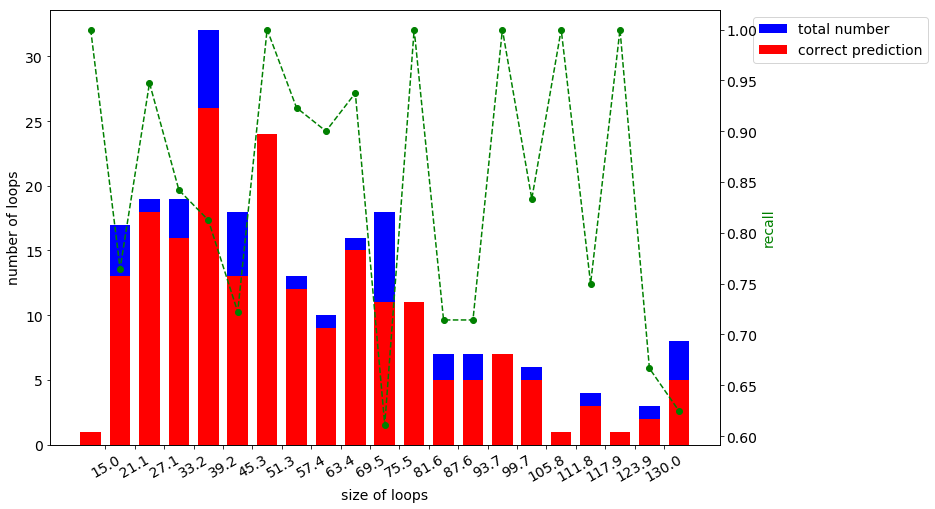

In [78]:
pr_plot_by_size(recalls, label='recall', num_bins=bins, size_range=sz_range)

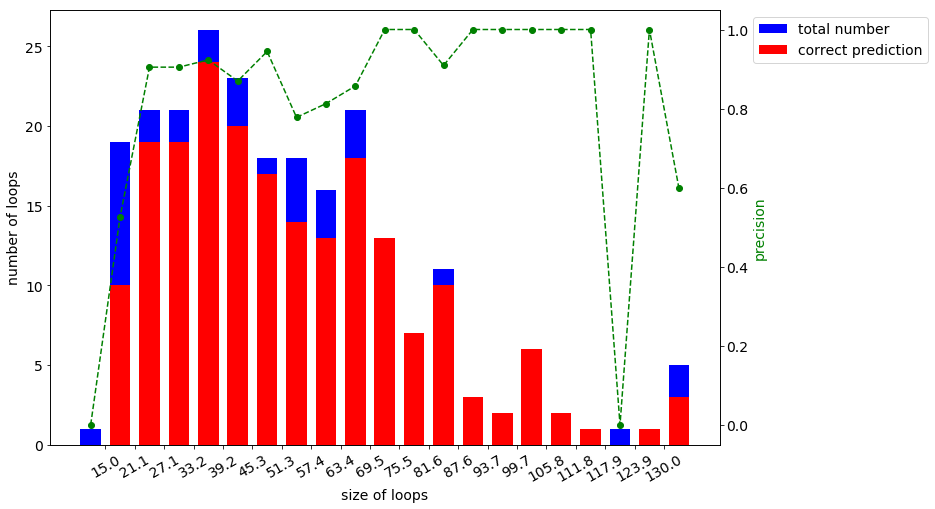

In [79]:
pr_plot_by_size(precisions, label='precision', num_bins=bins, size_range=sz_range)

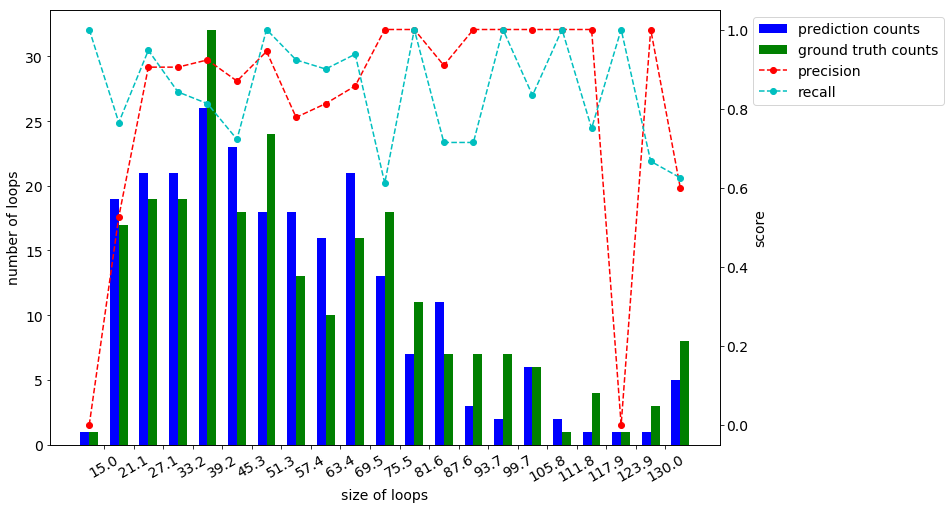

In [80]:
evaluation.size_distribution_comparison(precisions, recalls, num_bins=bins, size_range=sz_range)

# Development Tools

To crop image by the bounding boxes, use ```imageUtils.cropImage``` method

In [14]:
subimages, _ = imageUtils.cropImage(img_0, bbs_1)

To show an image, use ```imageUtils.showImage``` method

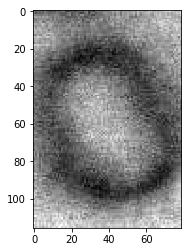

In [15]:
imageUtils.showImage(subimages[6])

To save image, use ```write_image``` method

In [ ]:
write_image(subimages[6], "./subimage6.jpg")